In [ ]:
# Import libraries here
import inspect
import time
import warnings
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

A `wrangle` function that will extract the PM2.5 readings from the site that has the most total readings in the Dar es Salaam collection. The function should do the following steps:

1. Localize reading time stamps to the timezone for `"Africa/Dar_es_Salaam"`.
2. Remove all outlier PM2.5 readings that are above 100.
3. Resample the data to provide the mean PM2.5 reading for each hour.
4. Impute any missing values using the forward-will method.
5. Return a Series `y`.

In [ ]:
df = pd.read_csv('/content/air_quality_dar_es_salaam.csv')

df['timestamp'] = pd.to_datetime(df['timestamp'])

In [ ]:
def wrangle(path):

    # Read results into DataFrame
    df = pd.read_csv(path)

    df['timestamp'] = pd.to_datetime(df['timestamp'])

    df = df.set_index("timestamp")

    # Localize timezone
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Dar_es_Salaam")

    # Remove outliers
    df = df[df["P2"] <= 100]

    # Resample and forward-fill
    y = df['P2'].resample('1H').mean().fillna(method='ffill')

    return y

Use your `wrangle` function to query the `dar` collection and return your cleaned results.

In [ ]:
y = wrangle('/content/air_quality_dar_es_salaam.csv')
y.head()

timestamp
2018-01-01 03:00:00+03:00    9.456327
2018-01-01 04:00:00+03:00    9.400833
2018-01-01 05:00:00+03:00    9.331458
2018-01-01 06:00:00+03:00    9.528776
2018-01-01 07:00:00+03:00    8.861250
Freq: H, Name: P2, dtype: float64

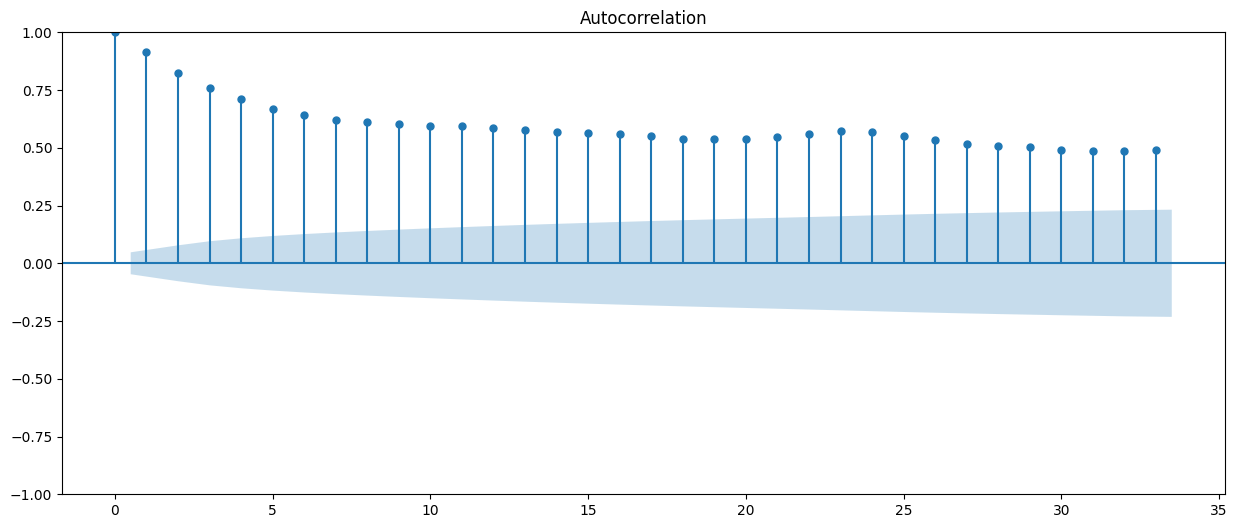

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

plot_acf(y, ax=ax);

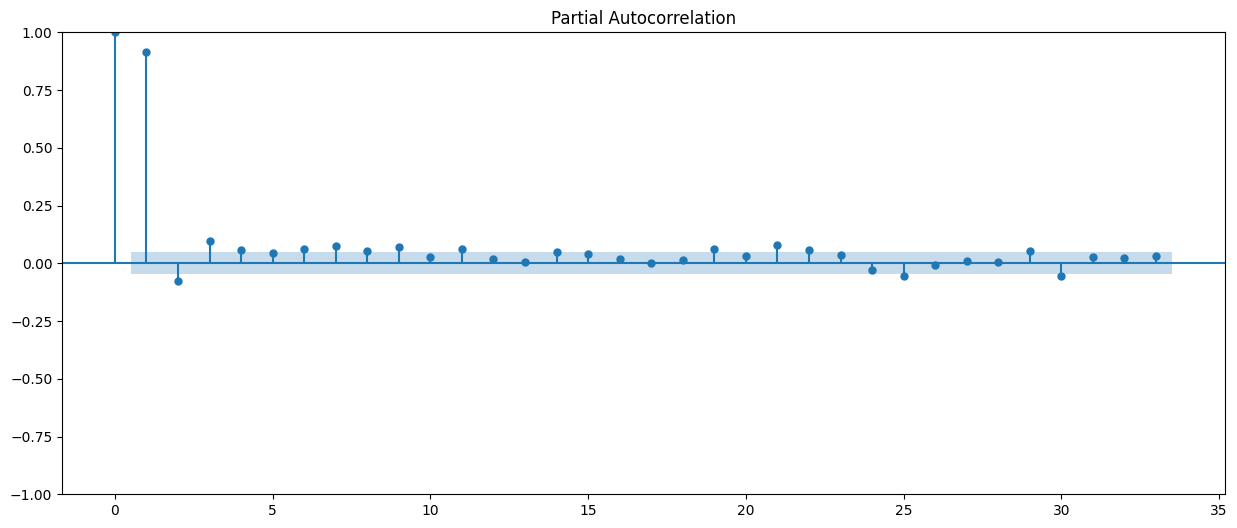

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax);


## Split

The first 90% of the data should be in your training set. The remaining 10% should be in the test set.

In [ ]:
cutoff = int(len(y) * 0.9)

y_train = y.iloc[:cutoff]
y_test = y.iloc[cutoff:]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1533,)
y_test shape: (171,)


# Build Model

## Baseline

In [ ]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)

Mean P2 Reading: 8.617582545265428
Baseline MAE: 4.07658759405218


## Hyperparameters

In [ ]:
p_params = range(1, 31)
mae_grid = []
for p in p_params:
    start_time = time.time()
    # Train model
    model = AutoReg(y_train, lags=p).fit()
    # Calculate model training time
    elapsed_time = round(time.time() - start_time, 2)
    print(f"Trained ARIMA {p} in {elapsed_time} seconds.")
    # Generate in-sample (training) predictions
    y_pred = model.predict().dropna()
    # Calculate training MAE
    mae = mean_absolute_error(y_train.iloc[p:], y_pred)
    # Append MAE to list in dictionary
    mae_grid.append(mae)

mae_series = pd.Series(mae_grid, name="mae", index=p_params)
mae_series.head()

Trained ARIMA 1 in 0.02 seconds.
Trained ARIMA 2 in 0.01 seconds.
Trained ARIMA 3 in 0.0 seconds.
Trained ARIMA 4 in 0.0 seconds.
Trained ARIMA 5 in 0.0 seconds.
Trained ARIMA 6 in 0.0 seconds.
Trained ARIMA 7 in 0.0 seconds.
Trained ARIMA 8 in 0.0 seconds.
Trained ARIMA 9 in 0.0 seconds.
Trained ARIMA 10 in 0.0 seconds.
Trained ARIMA 11 in 0.01 seconds.
Trained ARIMA 12 in 0.01 seconds.
Trained ARIMA 13 in 0.0 seconds.
Trained ARIMA 14 in 0.0 seconds.
Trained ARIMA 15 in 0.0 seconds.
Trained ARIMA 16 in 0.0 seconds.
Trained ARIMA 17 in 0.0 seconds.
Trained ARIMA 18 in 0.0 seconds.
Trained ARIMA 19 in 0.0 seconds.
Trained ARIMA 20 in 0.0 seconds.
Trained ARIMA 21 in 0.01 seconds.
Trained ARIMA 22 in 0.0 seconds.
Trained ARIMA 23 in 0.01 seconds.
Trained ARIMA 24 in 0.01 seconds.
Trained ARIMA 25 in 0.01 seconds.
Trained ARIMA 26 in 0.01 seconds.
Trained ARIMA 27 in 0.01 seconds.
Trained ARIMA 28 in 0.01 seconds.
Trained ARIMA 29 in 0.01 seconds.
Trained ARIMA 30 in 0.01 seconds.


1    0.947888
2    0.933894
3    0.920850
4    0.920153
5    0.919519
Name: mae, dtype: float64

In [ ]:
best_p = mae_series.argmin()
best_model = AutoReg(y_train, lags=best_p).fit()

In [ ]:
y_train_resid = best_model.resid
y_train_resid.name = "residuals"
y_train_resid.head()

timestamp
2018-01-02 06:00:00+03:00    1.469918
2018-01-02 07:00:00+03:00    1.732904
2018-01-02 08:00:00+03:00   -0.373988
2018-01-02 09:00:00+03:00   -0.563998
2018-01-02 10:00:00+03:00   -2.224239
Freq: H, Name: residuals, dtype: float64

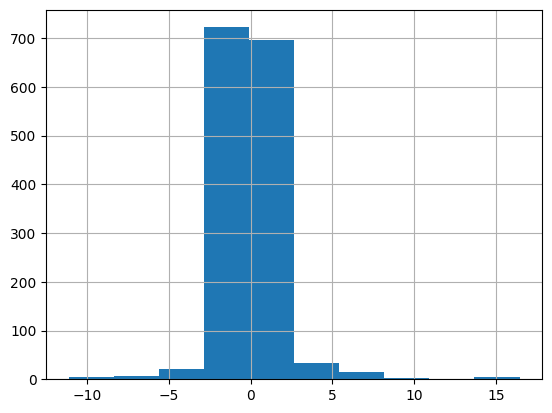

In [ ]:
# Plot histogram of residuals
y_train_resid.hist();


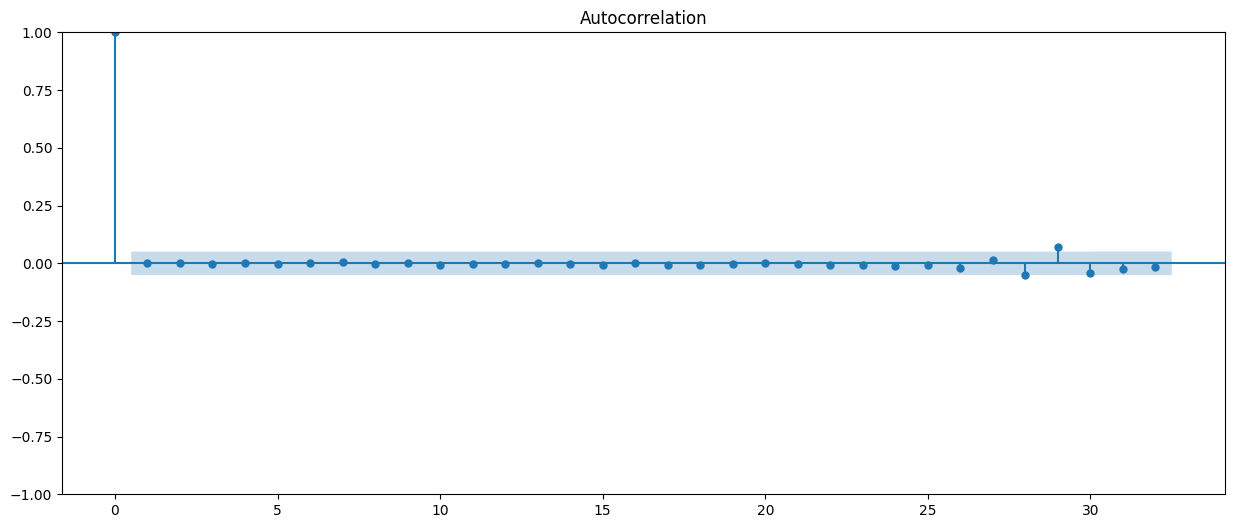

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax);


## Evaluate

In [ ]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history, lags=best_p).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

y_pred_wfv.name = "prediction"
y_pred_wfv.index.name = "timestamp"
y_pred_wfv.head()

timestamp
2018-03-06 00:00:00+03:00    8.049725
2018-03-06 01:00:00+03:00    8.680807
2018-03-06 02:00:00+03:00    6.276455
2018-03-06 03:00:00+03:00    6.308690
2018-03-06 04:00:00+03:00    7.155526
Freq: H, Name: prediction, dtype: float64

In [ ]:
mean_absolute_error(y_pred_wfv, y_test)

1.3371086328572686

# Communicate Results

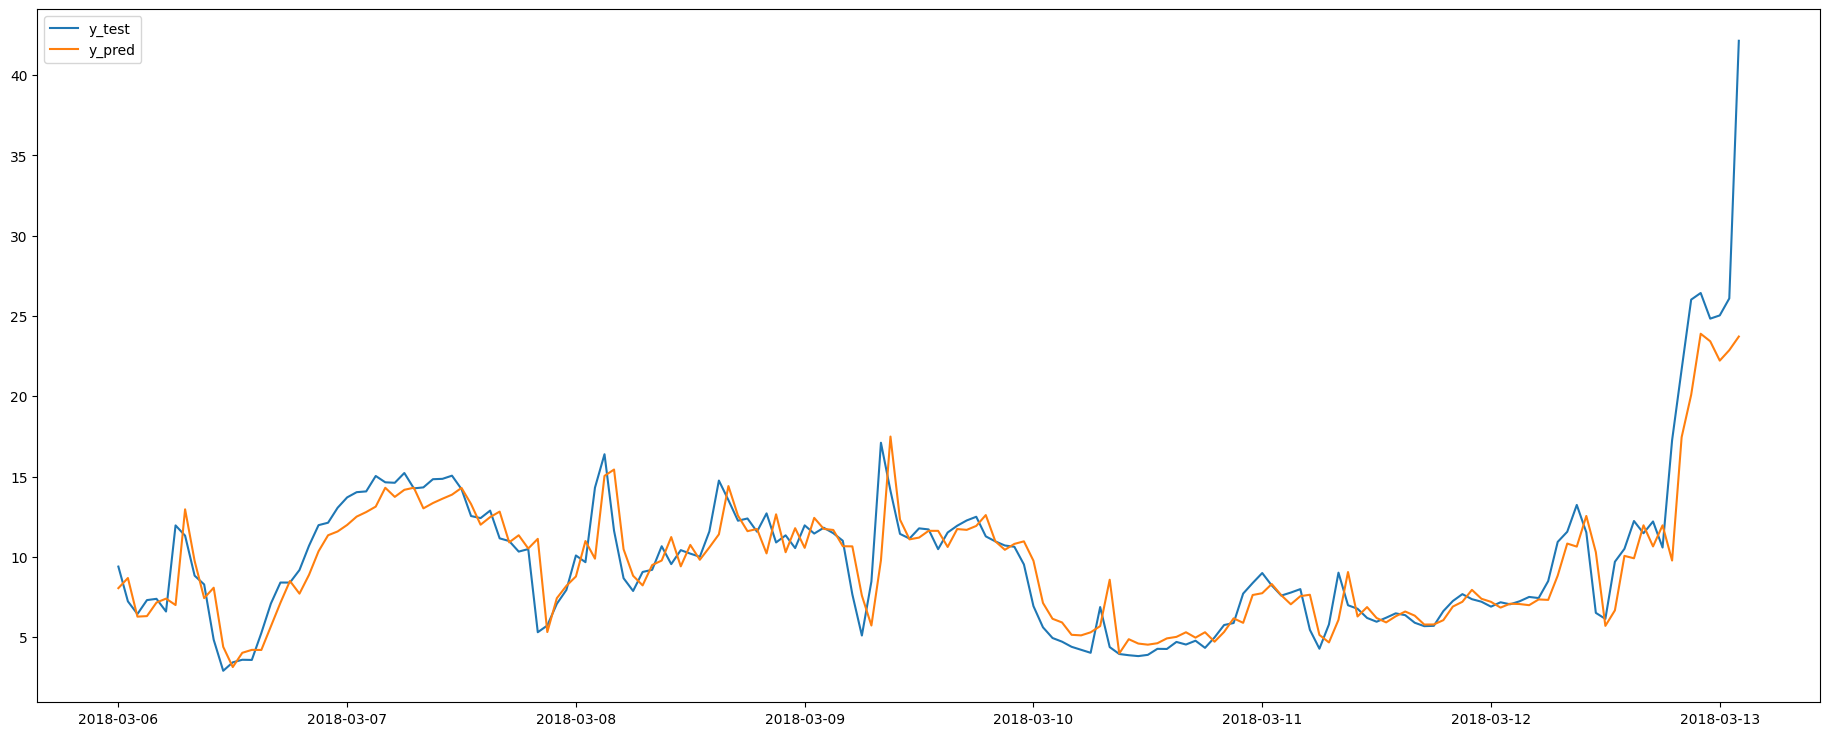

In [ ]:
plt.subplots(figsize=(23, 9))

plt.plot(y_test, label='y_test')
plt.plot(y_pred_wfv, label='y_pred')
plt.legend();